<a href="https://colab.research.google.com/github/mahyarhabibi/GenderGaps_Hollywood/blob/main/Codes/collaborative_filtering_pub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements Algorithm 1 in the paper to generate critics preference scores.

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
import altair as alt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

# Install Altair and activate its colab renderer.
print("Installing Altair...")
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('colab')
print("Done installing Altair.")

from google.colab import auth
from oauth2client.client import GoogleCredentials

Instructions for updating:
non-resource variables are not supported in the long term


Installing Altair...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-aysq1jo8
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-aysq1jo8
  fatal: unable to connect to github.com:
  github.com[0: 140.82.112.3]: errno=Connection timed out

ERROR: Command errored out with exit status 128: git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-aysq1jo8 Check the logs for full command output.
Done installing Altair.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Directories to read data and store results
#Please add the parent folder to your Google Drive
# Public Link: https://drive.google.com/drive/folders/1TYCDAJOCiLZw4TObcLac5GnL5YtwYnUD?usp=sharing
parent_dir = "/content/gdrive/MyDrive/GenderGaps_Hollywood/" # You may need to change the address
data_dir = os.path.join(parent_dir, 'Data/')
results_dir = os.path.join(parent_dir,'Results/')

In [ ]:
df_crevs = pd.read_pickle(data_dir + 'reviews_critics_merged.zip')
df_urevs = pd.read_pickle(data_dir + 'reviews_users_merged.zip')

c_cols = ['title_year', 'author', 'score', 'C_count']
u_cols = ['title_year', 'user', 'Uscore', 'U_count']

df_crevs  = df_crevs[c_cols]
df_urevs = df_urevs[u_cols]

In [ ]:
def make_user_ratings(df_urevs):
  # Make a rating data with only user_id, movie_idd, and score

  user_ids, users = pd.factorize(df_urevs['user'])
  movie_ids, movies = pd.factorize(df_urevs['title_year'])
  df_urevs['user_id'] = user_ids
  df_urevs['movie_id'] = movie_ids
  df_urevs = df_urevs.rename(columns={'Uscore': 'rating'})
  ratings = df_urevs[['user','user_id', 'title_year', 'movie_id', 'rating']]
  
  return ratings

In [ ]:
def build_ratings(df_revs):
  # Make a rating data with only user_id, movie_idd, and score
  try:
    df_revs = df_revs.rename(columns={'user': 'author'})
  except Exception as e:
    pass

  author_ids,  author = pd.factorize(df_revs['author'])
  movie_ids, movies = pd.factorize(df_revs['title_year'])
  df_revs['author_id'] = author_ids
  df_revs['movie_id'] = movie_ids

  df_revs = df_revs.rename(columns={'score': 'rating'})
  ratings = df_revs[['author','author_id', 'title_year', 'movie_id', 'rating']]
  
  return ratings

In [ ]:
def split_dataframe(df, holdout_fraction=0.1):
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [ ]:
def build_tensor(df_ratings):
  # Turn the sparse rating matrix to a sparse tensor in TF
  indices = df_ratings[['author_id', 'movie_id']].values
  values = df_ratings['rating'].values
  return tf.SparseTensor( indices=indices, values=values, 
                         dense_shape=[df_ratings['author_id'].nunique(),
                                      df_ratings['movie_id'].nunique()])

In [ ]:
def sparse_MSE(sparse_ratings, author_embeddings, movie_embeddings):
  predictions = tf.gather_nd(
      tf.matmul(author_embeddings, movie_embeddings, transpose_b=True),
      sparse_ratings.indices)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

In [ ]:
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [ ]:
#@title 
def build_model(ratings, embedding_dim=3, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_tensor(train_ratings)
  A_test = build_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_MSE(A_train, U, V)
  test_loss = sparse_MSE(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "movie_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [ ]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of movie ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_tensor(train_ratings)
  A_test = build_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_MSE(A_train, U, V)
  error_test = sparse_MSE(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"author_id": U, "movie_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

In [ ]:
df_ratings = df_crevs.loc[(df_crevs['C_count']>=100)]
df_ratings['R_count_top'] = df_ratings.groupby('title_year')['title_year'].transform('count')
df_ratings = df_ratings.loc[df_ratings['R_count_top']>=10]
ratings = build_ratings(df_ratings)
print(ratings['movie_id'].nunique())
print(ratings['author_id'].nunique())

7946
372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
movies = ratings[['title_year', 'movie_id']].drop_duplicates().sort_values(
    by='movie_id').reset_index(drop=True)
authors = ratings[['author', 'author_id']].drop_duplicates().sort_values(
    by='author_id').reset_index(drop=True)

In [ ]:
# Merge movie-id to critics score dataframe and 
# Keep Critics with at least 100 reviews (372 Critic)
df_crevs = df_crevs.loc[df_crevs.C_count>=100]
critics = df_crevs[['author', 'title_year' , 'score']]
critics.reset_index(drop=True, inplace=True)
critics = critics.merge(movies, on='title_year')
critics['movie_count'] = critics.groupby('author')['movie_id'].transform('count')
critics = critics.loc[critics['movie_count']>=10]
author_id, authors = pd.factorize(critics['author'].values)
critics['author_id'] = author_id

In [ ]:
# Regularized Matrix Factorization
def RMF(mat_ratings, eta = 0.2, embedd_dim=100, num_iter=1000, learn_rate=0.5):
  
    MF_model = build_regularized_model(
    mat_ratings, regularization_coeff= eta, gravity_coeff=0, embedding_dim=
    embedd_dim , init_stddev=0.05)

    MF_model.train(num_iterations=num_iter, learning_rate=learn_rate)
    U = np.array(MF_model.embeddings['author_id'])
    V = np.array(MF_model.embeddings['movie_id'])

    return U , V

In [ ]:
# Estimating Predicted Scores, changing the prediction dataframe inplace
def predict_score(author_id, ratings, df_cv_predictions, V, n_cv=10):
    df_temp = ratings.loc[ratings['author_id']==id].sort_values(by='movie_id')
    movie_ids = df_temp['movie_id'].values
    df_temp = df_temp.query("movie_id == @movie_ids")
    y = df_temp['rating'].values
    X_rmf = V_train[movie_ids,:]

    ridge = linear_model.Ridge(alpha=1)
    y_pred = cross_val_predict(ridge, X_rmf, y, cv=10)
    df_temp['predicted_score'] = y_pred

    return df_temp

In [ ]:
cols = list(ratings.columns.values)
cols.append('predicted_score')
df_cv_predictions = pd.DataFrame(columns= cols)

 iteration 1000: train_error_observed=264.271393, test_error_observed=378.753998, observed_loss=264.271393, regularization_loss=51.482521, gravity_loss=0.000000

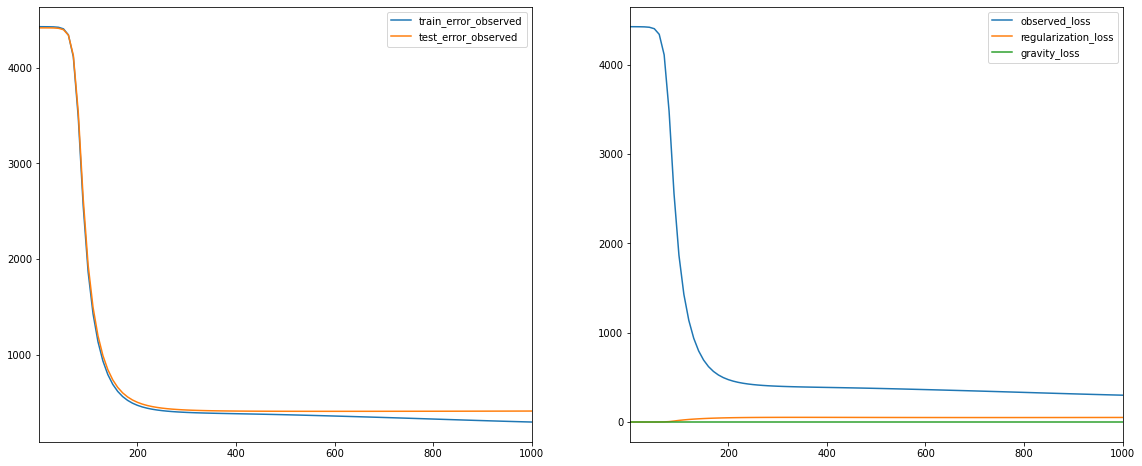

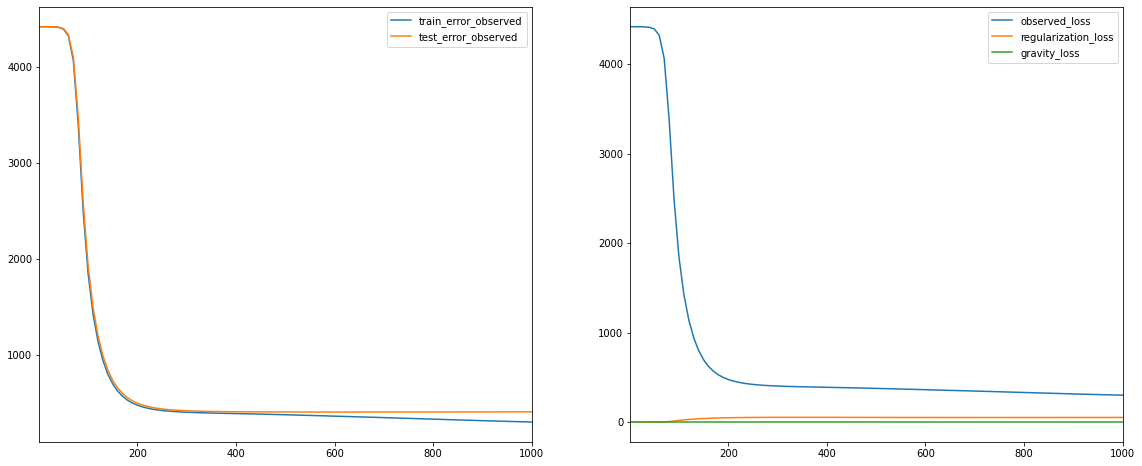

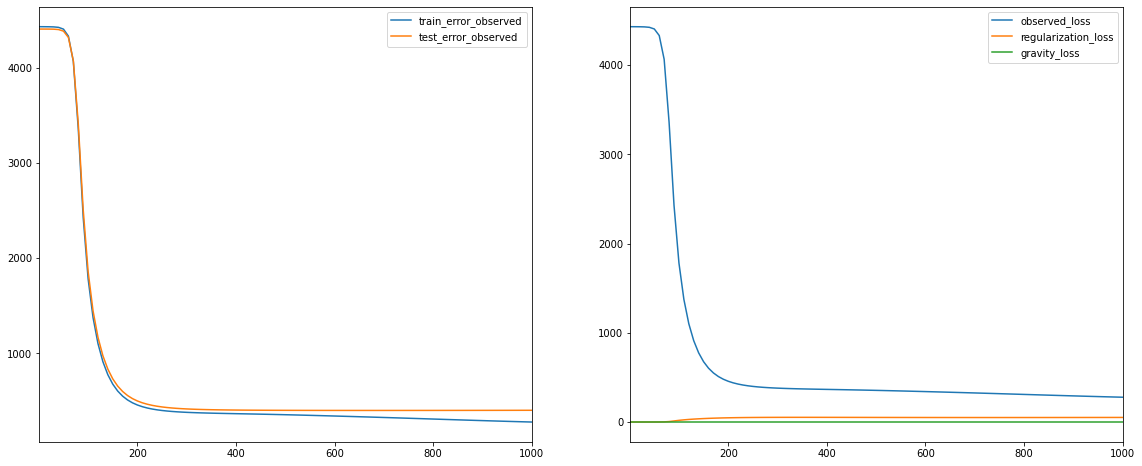

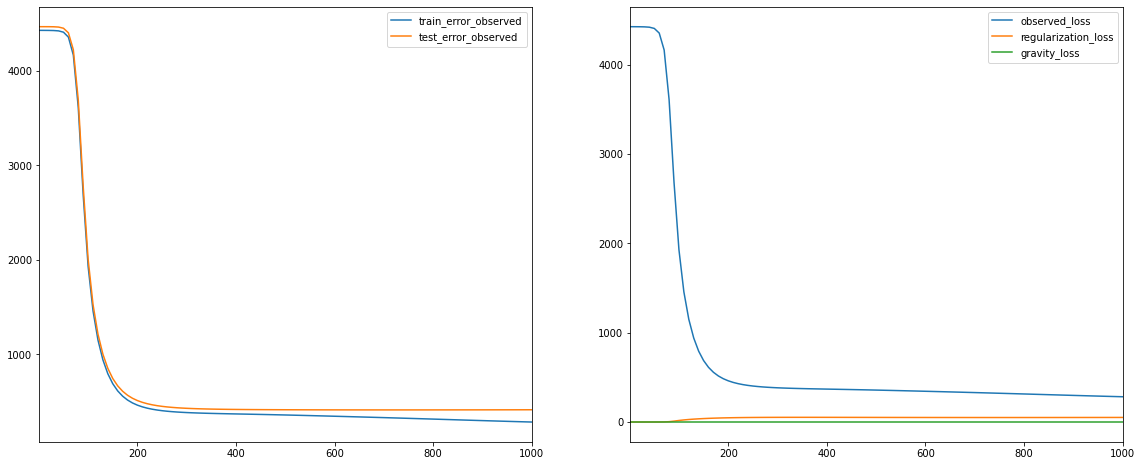

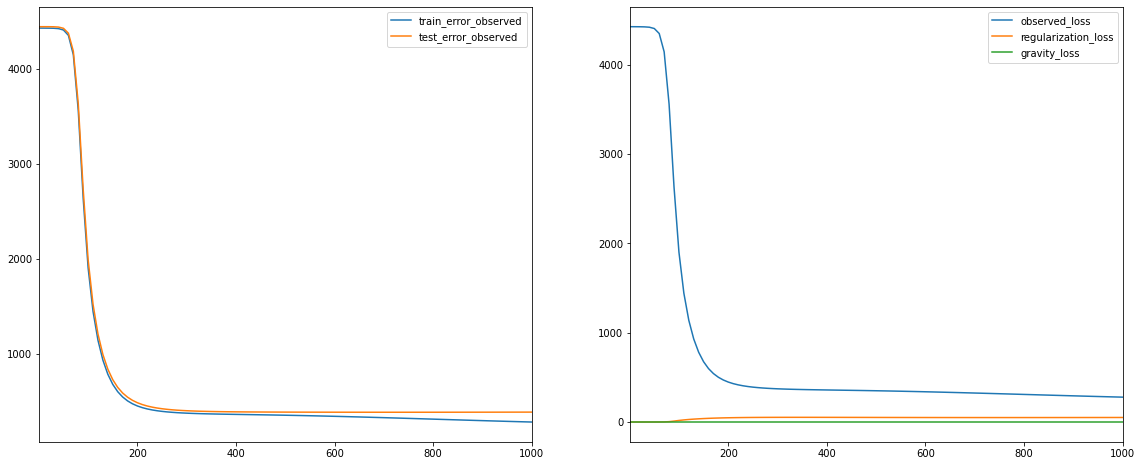

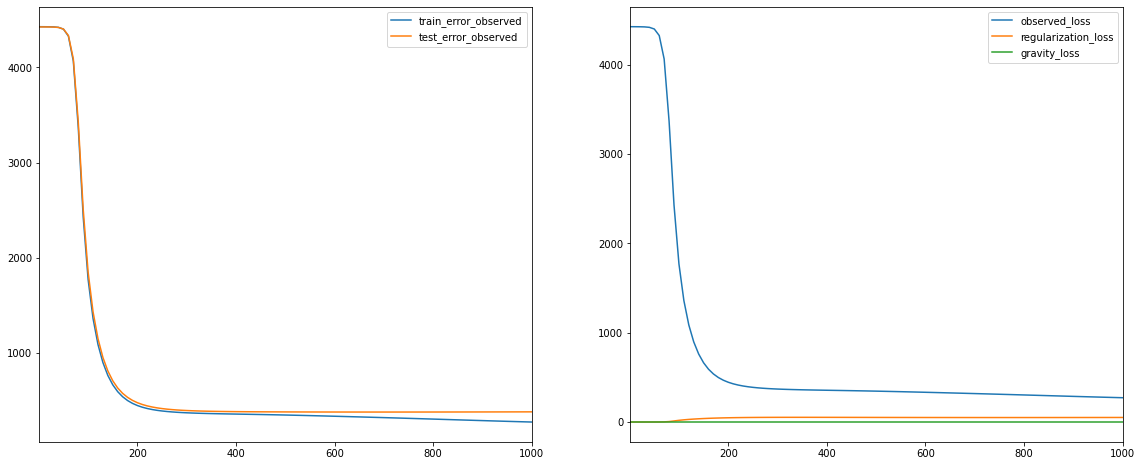

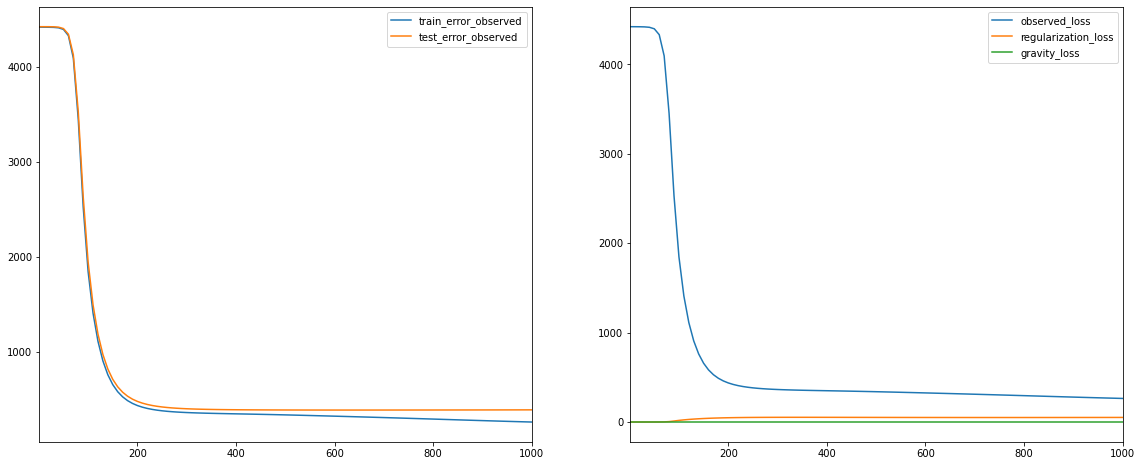

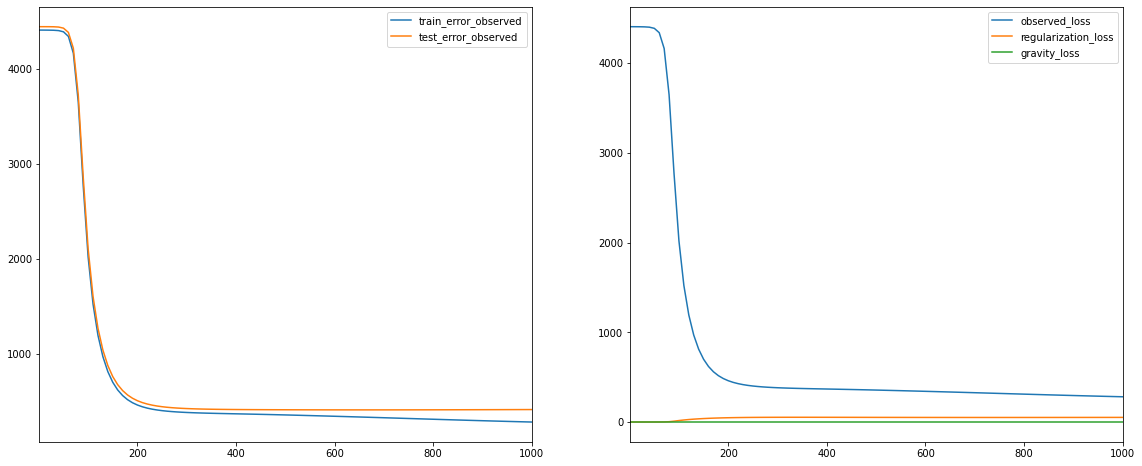

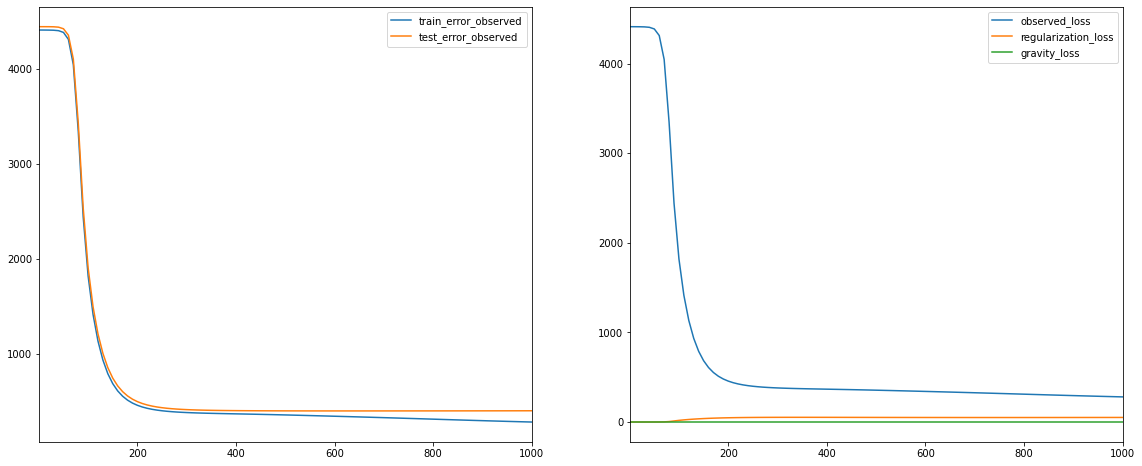

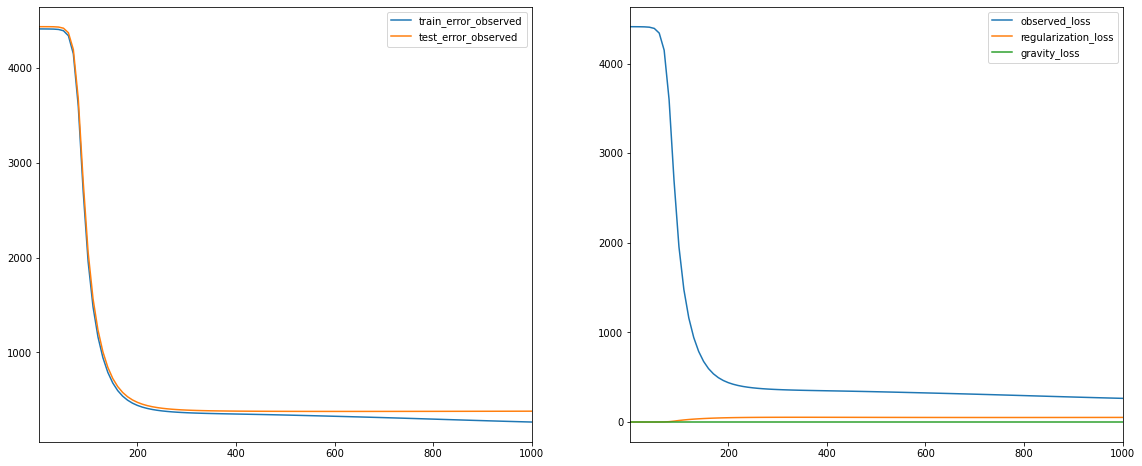

In [ ]:
# Split authors in 10 groups, use 9 to create embedding and the other to estimate \
# predicted scores.
from sklearn.model_selection import KFold
embedding_dim =100
kf = KFold(n_splits=10, shuffle=True, random_state=0)
author_ids = ratings.author_id.unique()

for train_index, test_index in kf.split(author_ids):

  X_train = ratings.loc[ratings['author_id'].isin(train_index)]

  U_train , V_train = RMF(X_train)

  for id in test_index:
     df_new_pred = predict_score(id, ratings, df_cv_predictions, V_train, n_cv=10)
     df_cv_predictions = df_cv_predictions.append(df_new_pred, ignore_index=True)


In [ ]:
df_cv_predictions['predicted_score'] = df_cv_predictions['predicted_score'].apply(float)
df_cv_predictions['rating'] = df_cv_predictions['rating'].apply(float)

In [ ]:
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.iolib.summary2 import summary_col

y , X = dmatrices('rating~ predicted_score', data=df_cv_predictions, return_type='dataframe')
reg = sm.OLS(y, X) 
reg_res = reg.fit()
print(reg_res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                 1.442e+05
Date:                Wed, 14 Sep 2022   Prob (F-statistic):               0.00
Time:                        13:58:24   Log-Likelihood:            -7.3053e+05
No. Observations:              175415   AIC:                         1.461e+06
Df Residuals:                  175413   BIC:                         1.461e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7082      0.153     

In [ ]:
#Storing the results
df_cv_predictions.to_pickle(results_dir + 'Critic_predicted_scores.pkl')